In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp /content/gdrive/My\ Drive/py_utils/*.* /content

In [0]:
!cp -R /content/gdrive/My\ Drive/weights /content

In [0]:
!cp -R /content/gdrive/My\ Drive/images /content

In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
!pip install git+https://github.com/rcmalli/keras-vggface.git --quiet

In [0]:
!pip install ipywidgets --quiet

In [0]:
import tensorflow as tf
print(tf.__version__)

1.15.2


In [0]:
import os, sys
import glob
import shutil
import zipfile
import numpy as np
import math
import tarfile
import re
import pickle
import requests
from tqdm import tqdm_notebook as tqdm
from numpy.random import random, permutation
from matplotlib import pyplot as plt
from PIL import Image
import time

In [0]:
from keras import backend as K
from keras.engine import  Model
from keras.layers import Flatten, Dense, Input, Lambda
from keras.utils.data_utils import get_file
from itertools import islice
from matplotlib import rcParams
import random
from PIL import ImageOps, ImageFont, ImageDraw 
import dlib
from skimage import io, transform
import tensorflow as tf
import ipywidgets as widgets
from keras_vggface.vggface import VGGFace
from keras.preprocessing import image
from keras_vggface import utils

Using TensorFlow backend.


In [0]:
from keras.layers import Add, Conv2D, Input, Lambda, Activation
from keras.models import Model
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255

In [0]:
from myutils import *

In [0]:
download_path = "/content/gdrive/My Drive/images/camera_download/"
resolved_path = "/content/gdrive/My Drive/images/resolved/"
face_path = "/content/gdrive/My Drive/images/cropped/"
selected_path = "/content/gdrive/My Drive/images/selected/"

In [0]:
# Remove folders if needed
import shutil
for path in [resolved_path, face_path, selected_path]:
  try:
    shutil.rmtree(path)
  except OSError as e:
    print("Warning: %s - %s." % (e.filename, e.strerror))    

In [0]:
# Create folders if needed
for path in [resolved_path, face_path, selected_path]:
  make_path(path)

# Construct EDSR model to increase resolution

In [0]:
def edsr(scale, num_filters, num_res_blocks):
    x_in = Input(shape=(None, None, 3))
    x = Normalization()(x_in)

    x = b = Conv2D(num_filters, 3, padding='same')(x)
    for i in range(num_res_blocks):
        b = res_block(b, num_filters)
    b = Conv2D(num_filters, 3, padding='same')(b)
    x = Add()([x, b])

    x = upsample(x, scale, num_filters)
    x = Conv2D(3, 3, padding='same')(x)
    x = Denormalization()(x)


    return Model(x_in, x, name="edsr")

In [0]:
def res_block(x_in, filters):
    x = Conv2D(filters, 3, padding='same')(x_in)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = Add()([x_in, x])
    return x

In [0]:
def upsample(x, scale, num_filters):
    def upsample_1(x, factor, name):
        x = Conv2D(num_filters * (factor ** 2), 3, padding='same')(x)
        return SubpixelConv2D(factor)(x)

    if scale == 2:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
    elif scale == 3:
        x = upsample_1(x, 3, name='conv2d_1_scale_3')
    elif scale == 4:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
        x = upsample_1(x, 2, name='conv2d_2_scale_2')

    return x

In [0]:
def SubpixelConv2D(scale):
    return Lambda(lambda x: tf.depth_to_space(x, scale))

In [0]:
def Normalization(rgb_mean=DIV2K_RGB_MEAN):
    return Lambda(lambda x: (x - rgb_mean) / 127.5)

In [0]:
def Denormalization(rgb_mean=DIV2K_RGB_MEAN):
    return Lambda(lambda x: x * 127.5 + rgb_mean)

In [0]:
# Number of residual blocks
depth = 16

# Super-resolution factor
scale = 4
num_filters=64

In [0]:
edsr_model = edsr(scale, num_filters, num_res_blocks=depth)

In [0]:
edsr_model.summary()

Model: "edsr"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 1792        lambda_2[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 6 36928       conv2d_1[0][0]                   
_______________________________________________________________________________________________

# Load pre-trained weights of *EDSR*

In [0]:
# Location of model weights (needed for demo)
weights_dir = f'weights/edsr-{depth}-x{scale}'
weights_file = os.path.join(weights_dir, 'weights.h5')

os.makedirs(weights_dir, exist_ok=True)

In [0]:
print(weights_file)

weights/edsr-16-x4/weights.h5


In [0]:
edsr_model.load_weights(weights_file)

# Create super resolution image

In [0]:
def load_image(path):
    return np.array(Image.open(path))

In [0]:
def resolve(model, lr):
    sr = model.predict(np.expand_dims(lr, axis=0))[0]
    sr = np.clip(sr, 0, 255)
    sr = sr.astype('uint8')
    return sr

In [0]:
def plot_sample(lr, sr):
    plt.figure(figsize=(20, 10))

    images = [lr, sr]
    titles = ['LR', f'SR (x{sr.shape[0] // lr.shape[0]})']

    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 2, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

In [0]:
def get_folder_name(img_file):  
  return img_file.split('_')[0].split('.')[0]

In [0]:
def correct_image(img):
  if img.shape[2] == 4:
    return cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
  elif img.shape[2] == 1:
    return cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  return img

In [0]:
# Read color images from camera_download and improve resolution
import cv2
for f in os.listdir(download_path):
    print(f)
    lr = load_image(download_path+f)
    # Check color channels
    lr = correct_image(lr)
    # Run super resolution
    sr = resolve(edsr_model, lr)
    # Save to resolved_path
    folder = resolved_path+get_folder_name(f)+'/'
    make_path(folder) 
    image_to_write = cv2.cvtColor(sr, cv2.COLOR_RGB2BGR)
    cv2.imwrite(folder+f, image_to_write)

Trishla_4.PNG
Trishla_2.PNG
Trishla_3.PNG
Mounica_1.PNG
Varun.PNG
Mounica_3.PNG
Mounica_2.PNG
Trishla_1.PNG
Venkat.jpg
Ashlesha_1.PNG
Ashlesha_2.PNG
Ashlesha_3.PNG
Ashlesha_4.PNG
Venkat_2.jpg
Venkat_3.jpg
Varun_2.PNG
Varun_3.PNG


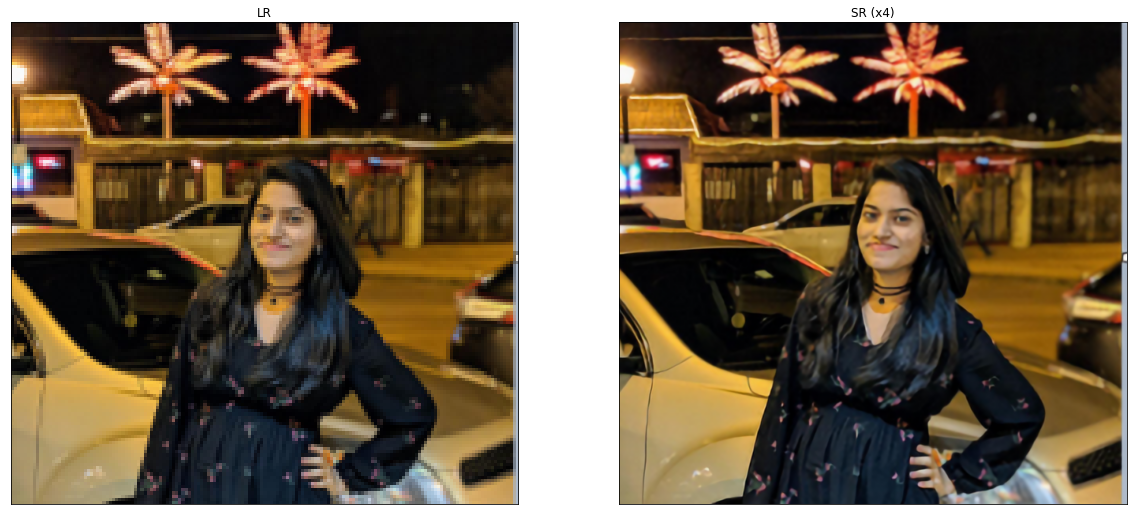

In [0]:
# Show images
img_file = "Ashlesha_1.PNG"
lr = load_image(download_path+img_file)
sr = load_image(resolved_path+get_folder_name(img_file)+'/'+img_file)          
plot_sample(lr, sr)

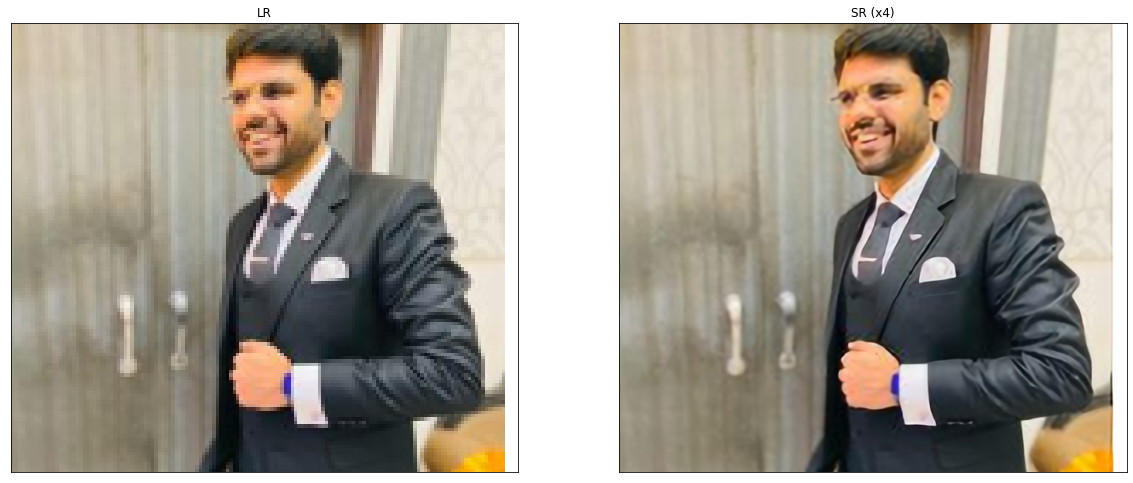

In [0]:
# Show images
img_file = "Varun_2.PNG"
lr = load_image(download_path+img_file)
sr = load_image(resolved_path+get_folder_name(img_file)+'/'+img_file)          
plot_sample(lr, sr)

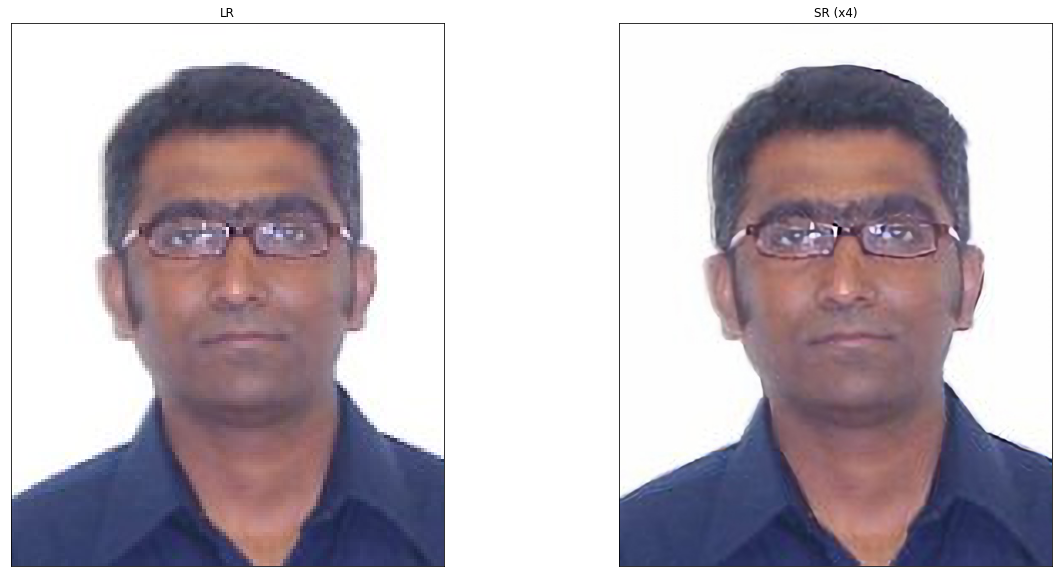

In [0]:
# Show images
img_file = "Venkat.jpg"
lr = load_image(download_path+img_file)
sr = load_image(resolved_path+get_folder_name(img_file)+'/'+img_file)          
plot_sample(lr, sr)

### Detecting and cropping images

In [0]:
def detect_faces(image):

    # Create a face detector
    face_detector = dlib.get_frontal_face_detector()

    # Run detector and get bounding boxes of the faces on image.
    detected_faces = face_detector(image, 1)
    face_frames = [(x.left(), x.top(),
                    x.right(), x.bottom()) for x in detected_faces]

    return face_frames

In [0]:
def create_cropped_images(original_path, cropped_path):
  for f in os.listdir(original_path):
    print(f)
    name_cropped_dir = cropped_path+f+'/'
    make_path(name_cropped_dir)
    for r, d, fil_list in os.walk(original_path+f):
      for fname in fil_list:
        image = io.imread(original_path+f+'/'+fname)
        detected_faces = detect_faces(image)
        if (len(detected_faces)):
          face = Image.fromarray(image).crop(detected_faces[0])
          face.save(name_cropped_dir+fname)

In [0]:
files_in_path(resolved_path)

{'Ashlesha': 4, 'Mounica': 3, 'Trishla': 4, 'Varun': 3, 'Venkat': 3}

In [0]:
create_cropped_images(resolved_path, face_path)

Trishla
Mounica
Varun
Venkat
Ashlesha


### Selecting image pairs

In [0]:
def checkboxes (data):
  names = []
  checkbox_objects = []
  for item in data:
      checkbox_objects.append(widgets.Checkbox(value=False, description=item))
      names.append(item)

  arg_dict = {names[i]: checkbox for i, checkbox in enumerate(checkbox_objects)}

  ui = widgets.VBox(children=checkbox_objects)

  selected_data = []
  def select_data(**kwargs):
      selected_data.clear()
      for key in kwargs:
          if kwargs[key] is True:
              selected_data.append(key)
              
  out = widgets.interactive_output(select_data, arg_dict)
  return ui, selected_data

In [0]:
def show_multiple_images(path):
  fig = plt.figure(figsize=(9, 13))
  fnums = len(os.listdir(path))
  columns = 4
  rows = math.ceil(fnums/columns)
  ax = []
  for r, d, fil_list in os.walk(path):
      for i, fname in enumerate(fil_list):
        img=Image.open(path+'/'+ fname)
        ax.append( fig.add_subplot(rows, columns, i+1) )
        ax[-1].set_title(fname)  # set title
        plt.imshow(img, alpha=1)
      plt.show()
  ui, selected_data = checkboxes (fil_list)
  display(ui)
  return selected_data, r

In [0]:
def show_multiple_images_2(path):
  fig = plt.figure(figsize=(19, 6))
  folder = os.listdir(path)
  fnums = sum([len(files) for r, d, files in os.walk(path)])
  print(fnums)
  columns = 7
  rows = math.ceil(fnums/columns)
  ax = []
  i = 1
  for f in folder:
    for r, d, fil_list in os.walk(path+f):
      for fname in fil_list:
          img=Image.open(path+f+'/'+ fname)
          ax.append(fig.add_subplot(rows, columns, i) )
          i+=1
          ax[-1].set_title(fname)  # set title
          plt.imshow(img, alpha=1)
  plt.show()

14


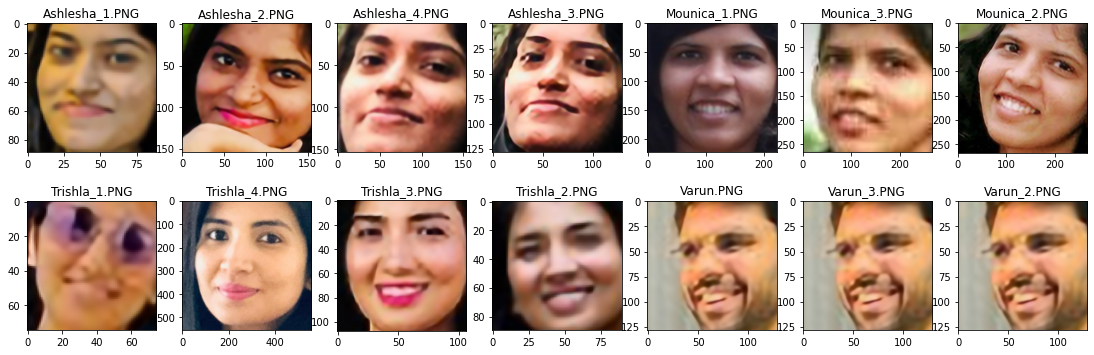

In [0]:
show_multiple_images_2(selected_path)

In [0]:
def move_selected(selection, org_path, des_path):
  try:
    shutil.rmtree(des_path)
  except OSError as e:
    print("Warning: %s - %s." % (e.filename, e.strerror))   
  make_path(des_path)
  files = []
  for fname in selection:
    shutil.copyfile(org_path+fname, des_path+fname)
    files.append(des_path+fname)
  show_multiple_images(des_path)

In [0]:
shutil.rmtree(selected_path)

In [0]:
os.mkdir(selected_path)

In [0]:
# selection, path = show_multiple_images(face_path+'Ashlesha')
# Copy face_path to selected_path
from distutils.dir_util import copy_tree
copy_tree(face_path, selected_path)

In [0]:
shutil.rmtree(selected_path+"Venkat")

### Model selection

In [0]:
senet_model = VGGFace(model='senet50', include_top=False, input_shape=(224, 224, 3))














104947712/104944616 [==============================] - 2s 0us/step


In [0]:
senet_model.summary()

Model: "vggface_senet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
____________________________________________________________________________________

In [0]:
def fr_model():
  last_layer = senet_model.get_layer('avg_pool').output
  X = Flatten(name='flatten')(last_layer)
  X = Dense(128, name='dense_layer')(X)
  # L2 normalization
  out = Lambda(lambda  x: K.l2_normalize(x,axis=1))(X)

  # Create model instance
  model = Model(senet_model.input, out, name='fr_model')
  return model


In [0]:
model = fr_model()

In [0]:
model.summary()

Model: "fr_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________________

### Image encoding

In [0]:
def img_to_encoding(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = utils.preprocess_input(x, version=2)
    embedding = model.predict(x)
    return embedding

In [0]:
dist = {}
for f in os.listdir(selected_path):

  for r, d, fil_list in os.walk(selected_path+f):
    
    dir_list = r.split("/")
    label = dir_list[-1].strip()
    encodes = []
    for fname in fil_list:
      encoding = img_to_encoding(selected_path+label+'/'+fname, model)
      encodes.append(encoding)
    l2_dist = np.linalg.norm(encodes[0]-encodes[1])
    dist[label] = round(l2_dist, 3)
print(dist)


{'Ashlesha': 0.71, 'Mounica': 0.516, 'Trishla': 1.139, 'Varun': 0.0}


In [0]:
col_data = {}
all_flist = []
all_encodes = {}
for f in os.listdir(selected_path):

  for r, d, fil_list in os.walk(selected_path+f):
    for fname in fil_list:
      fname_only = fname.split('.')[0]
      all_flist.append(fname_only)
      print(fname_only)
      enc = img_to_encoding(selected_path+f+'/'+fname, model)
      all_encodes[fname_only] = enc      

Ashlesha_1
Ashlesha_2
Ashlesha_4
Ashlesha_3
Mounica_1
Mounica_3
Mounica_2
Trishla_1
Trishla_4
Trishla_3
Trishla_2
Varun
Varun_3
Varun_2


In [0]:
print(len(all_encodes['Ashlesha_1'][0]))

128


In [0]:
for fname in all_flist:
  enc_1 = all_encodes[fname]
  enc_list = []
  for key, val in all_encodes.items():
    l2_dist = np.linalg.norm(val-enc_1)
    enc_list.append(l2_dist)
  col_data[fname] = enc_list

print(col_data)

{'Ashlesha_1': [0.0, 0.7096837, 0.78964967, 0.7890293, 1.0358407, 1.0968572, 1.0225344, 1.0903652, 1.0200698, 1.1109139, 0.96933794, 1.3177706, 1.3177706, 1.3177706], 'Ashlesha_2': [0.7096837, 0.0, 0.58936465, 0.5315257, 1.0338882, 1.0487156, 0.9691667, 1.0257423, 1.0003695, 1.0642592, 0.9832346, 1.3345065, 1.3345065, 1.3345065], 'Ashlesha_4': [0.78964967, 0.58936465, 0.0, 0.46059868, 1.1352932, 1.1274829, 1.0769337, 1.0098931, 0.9570976, 1.0115533, 0.90646285, 1.2359562, 1.2359562, 1.2359562], 'Ashlesha_3': [0.7890293, 0.5315257, 0.46059868, 0.0, 1.0603093, 1.0698696, 0.9656862, 0.9460302, 0.89843225, 0.97013664, 0.9017388, 1.2702196, 1.2702196, 1.2702196], 'Mounica_1': [1.0358407, 1.0338882, 1.1352932, 1.0603093, 0.0, 0.5162855, 0.39157835, 1.241656, 0.99574226, 1.1721729, 1.1978345, 1.1168715, 1.1168715, 1.1168715], 'Mounica_3': [1.0968572, 1.0487156, 1.1274829, 1.0698696, 0.5162855, 0.0, 0.4921942, 1.256727, 1.0274441, 1.1772949, 1.1561089, 1.0975605, 1.0975605, 1.0975605], 'Mounic

### Visualization

In [0]:
import pandas as pd
df = pd.DataFrame(col_data,columns=all_flist)
row_names = {}
for i in range(0, len(df)):
  row_names[i] = all_flist[i]
renamed_df = df.rename(row_names)
renamed_df

,Ashlesha_1,Ashlesha_2,Ashlesha_4,Ashlesha_3,Mounica_1,Mounica_3,Mounica_2,Trishla_1,Trishla_4,Trishla_3,Trishla_2,Varun,Varun_3,Varun_2
Ashlesha_1,0.000000,0.709684,0.789650,0.789029,1.035841,1.096857,1.022534,1.090365,1.020070,1.110914,0.969338,1.317771,1.317771,1.317771
Ashlesha_2,0.709684,0.000000,0.589365,0.531526,1.033888,1.048716,0.969167,1.025742,1.000370,1.064259,0.983235,1.334507,1.334507,1.334507
Ashlesha_4,0.789650,0.589365,0.000000,0.460599,1.135293,1.127483,1.076934,1.009893,0.957098,1.011553,0.906463,1.235956,1.235956,1.235956
Ashlesha_3,0.789029,0.531526,0.460599,0.000000,1.060309,1.069870,0.965686,0.946030,0.898432,0.970137,0.901739,1.270220,1.270220,1.270220
Mounica_1,1.035841,1.033888,1.135293,1.060309,0.000000,0.516285,0.391578,1.241656,0.995742,1.172173,1.197834,1.116871,1.116871,1.116871
Mounica_3,1.096857,1.048716,1.127483,1.069870,0.516285,0.000000,0.492194,1.256727,1.027444,1.177295,1.156109,1.097561,1.097561,1.097561
Mounica_2,1.022534,0.969167,1.076934,0.965686,0.391578,0.492194,0.000000,1.181261,0.974375,1.150223,1.135300,1.136190,1.136190,1.136190
Trishla_1,1.090365,1.025742,1.009893,0.946030,1.241656,1.256727,1.181261,0.000000,1.138997,1.126714,1.147178,1.262732,1.262732,1.262732
Trishla_4,1.020070,1.000370,0.957098,0.898432,0.995742,1.027444,0.974375,1.138997,0.000000,0.793494,0.840813,1.198750,1.198750,1.198750
Trishla_3,1.110914,1.064259,1.011553,0.970137,1.172173,1.177295,1.150223,1.126714,0.793494,0.000000,0.806740,1.164479,1.164479,1.164479


In [0]:
import seaborn as sns

color_map = sns.light_palette("green", as_cmap=True)

styled_df = renamed_df.style.background_gradient(cmap=color_map)
styled_df

,Ashlesha_1,Ashlesha_2,Ashlesha_4,Ashlesha_3,Mounica_1,Mounica_3,Mounica_2,Trishla_1,Trishla_4,Trishla_3,Trishla_2,Varun,Varun_3,Varun_2
Ashlesha_1,0.000000,0.709684,0.789650,0.789029,1.035841,1.096857,1.022534,1.090365,1.020070,1.110914,0.969338,1.317771,1.317771,1.317771
Ashlesha_2,0.709684,0.000000,0.589365,0.531526,1.033888,1.048716,0.969167,1.025742,1.000370,1.064259,0.983235,1.334507,1.334507,1.334507
Ashlesha_4,0.789650,0.589365,0.000000,0.460599,1.135293,1.127483,1.076934,1.009893,0.957098,1.011553,0.906463,1.235956,1.235956,1.235956
Ashlesha_3,0.789029,0.531526,0.460599,0.000000,1.060309,1.069870,0.965686,0.946030,0.898432,0.970137,0.901739,1.270220,1.270220,1.270220
Mounica_1,1.035841,1.033888,1.135293,1.060309,0.000000,0.516285,0.391578,1.241656,0.995742,1.172173,1.197834,1.116871,1.116871,1.116871
Mounica_3,1.096857,1.048716,1.127483,1.069870,0.516285,0.000000,0.492194,1.256727,1.027444,1.177295,1.156109,1.097561,1.097561,1.097561
Mounica_2,1.022534,0.969167,1.076934,0.965686,0.391578,0.492194,0.000000,1.181261,0.974375,1.150223,1.135300,1.136190,1.136190,1.136190
Trishla_1,1.090365,1.025742,1.009893,0.946030,1.241656,1.256727,1.181261,0.000000,1.138997,1.126714,1.147178,1.262732,1.262732,1.262732
Trishla_4,1.020070,1.000370,0.957098,0.898432,0.995742,1.027444,0.974375,1.138997,0.000000,0.793494,0.840813,1.198750,1.198750,1.198750
Trishla_3,1.110914,1.064259,1.011553,0.970137,1.172173,1.177295,1.150223,1.126714,0.793494,0.000000,0.806740,1.164479,1.164479,1.164479


In [0]:
database_list = ['Ashlesha']

### Preparing 2 encoding databases

In [0]:
# separate the encodings for each person into 2 dicts
# dict 1 will be the encoding database in the baby sister list
db_encodes = {}
# dict 2 will be encoding done from door camera
camera_encodes = {}
for key, val in all_encodes.items():
  object_name = key.split('_')[0]
  camera_encodes[object_name] = val
  if object_name in database_list:
    db_encodes[object_name] = val

In [0]:
print(db_encodes)

{'Ashlesha': array([[-0.05245959,  0.02123725, -0.10128747,  0.07244553,  0.06940155,
        -0.007105  , -0.05189391,  0.09628043,  0.17222404, -0.08810094,
        -0.0369979 , -0.00899149,  0.07415661,  0.01555591, -0.00699323,
         0.13513088,  0.14570285,  0.05177578,  0.02895219,  0.25198087,
        -0.10721941,  0.24441701, -0.02710276, -0.15307008, -0.07294665,
        -0.11643475, -0.15674539,  0.00967274,  0.03905555,  0.03479269,
         0.03499197, -0.037541  ,  0.02618359,  0.09008825,  0.02003536,
        -0.03700532,  0.161409  , -0.02197075, -0.0546577 , -0.11311432,
        -0.06422185,  0.042288  ,  0.03113827,  0.01021193,  0.00676116,
         0.15550946, -0.0440511 , -0.02757791, -0.04658135,  0.10685503,
        -0.08452594,  0.05647497, -0.02624101,  0.12099165,  0.01249323,
         0.17755161, -0.00857055,  0.0098881 ,  0.03404047, -0.01063371,
        -0.00852366, -0.11096313,  0.12991454,  0.02797152,  0.02544999,
         0.02678843,  0.05517131, -0.0

In [0]:
print(camera_encodes)

{'Ashlesha': array([[-0.05245959,  0.02123725, -0.10128747,  0.07244553,  0.06940155,
        -0.007105  , -0.05189391,  0.09628043,  0.17222404, -0.08810094,
        -0.0369979 , -0.00899149,  0.07415661,  0.01555591, -0.00699323,
         0.13513088,  0.14570285,  0.05177578,  0.02895219,  0.25198087,
        -0.10721941,  0.24441701, -0.02710276, -0.15307008, -0.07294665,
        -0.11643475, -0.15674539,  0.00967274,  0.03905555,  0.03479269,
         0.03499197, -0.037541  ,  0.02618359,  0.09008825,  0.02003536,
        -0.03700532,  0.161409  , -0.02197075, -0.0546577 , -0.11311432,
        -0.06422185,  0.042288  ,  0.03113827,  0.01021193,  0.00676116,
         0.15550946, -0.0440511 , -0.02757791, -0.04658135,  0.10685503,
        -0.08452594,  0.05647497, -0.02624101,  0.12099165,  0.01249323,
         0.17755161, -0.00857055,  0.0098881 ,  0.03404047, -0.01063371,
        -0.00852366, -0.11096313,  0.12991454,  0.02797152,  0.02544999,
         0.02678843,  0.05517131, -0.0

# Someone walks in. Check if she/he is a criminal

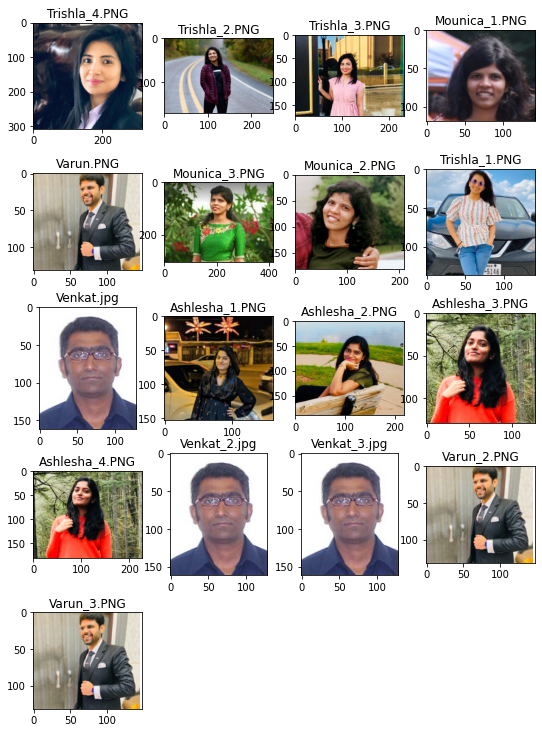

In [0]:
#Select photo from camera download. (Assuming Venkat walks in)
selection, path = show_multiple_images(download_path)

In [0]:
# Define the function to detect, crop face from the selected camera photo and save to camera path
def detect_from_camera(selection, path, camera_path): 
  if os.path.exists(camera_path):
    shutil.rmtree(camera_path)
  os.makedirs(camera_path)
  files = []
  for fname in selection:
    print(fname)
    lr3 = correct_image(load_image(path + fname))
    sr3 = resolve(edsr_model, lr3)
    image_to_write3 = cv2.cvtColor(sr3, cv2.COLOR_RGB2BGR)
    cv2.imwrite(camera_path+fname, image_to_write3)    
    image = io.imread(camera_path+fname)
    detected_faces = detect_faces(image)
    if (len(detected_faces)):
      face = Image.fromarray(image).crop(detected_faces[0])
      face.save(camera_path + fname)
      files.append(camera_path+fname)
    else:
      print("Can not detect any face from the selected image")
  show_multiple_images(camera_path)

Venkat.jpg


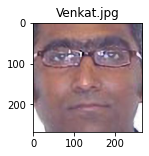

In [0]:
#Crop and Save the selected image 
camera_path = "/content/gdrive/My Drive/images/camera/"
detect_from_camera(selection, path, camera_path)

In [0]:
#Encoding the selected image
person = img_to_encoding(camera_path + selection[0], model)

same_dist_camera = {}                         #door camera database encoding
for name in camera_encodes.keys():
  enc_camera = camera_encodes[name]
  l2_dist = np.linalg.norm(person-enc_camera)
  same_dist_camera[name] = l2_dist

same_dist_db = {}                             #database encoding 
for name in db_encodes.keys():
  enc_db = db_encodes[name]
  l2_dist = np.linalg.norm(person-enc_db)
  same_dist_db[name] = l2_dist

min_dist = min(same_dist_camera.values())       
name = [key for key in same_dist_camera if same_dist_camera[key] == min_dist]

if min_dist > 0.8:
  print("Not a criminal!")
else:                                           
  min_dist2 = min(same_dist_db.values()) 
  name2 = [key for key in same_dist_db if same_dist_db[key] == min_dist2]
  if name2 == name:
    print("A criminal recognized - {}! Alert sent to Police.".format(name[0]))
  else:
    print("Not a criminal!") 

Not a criminal!


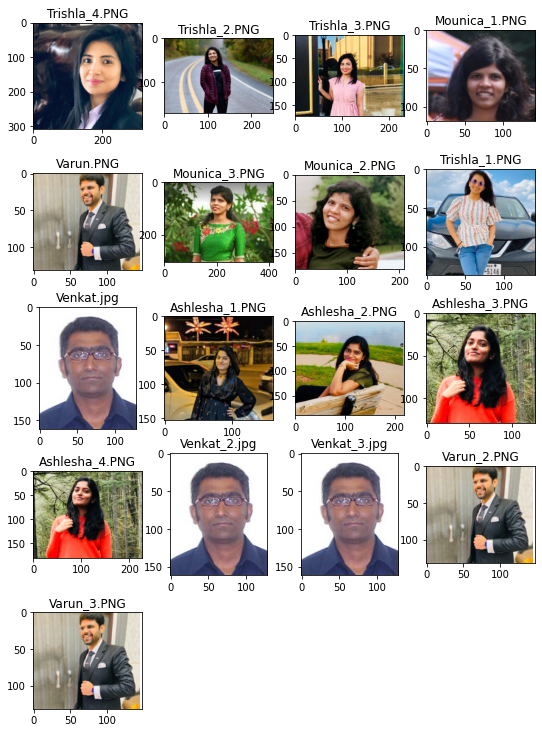

In [0]:
#Select photo from camera download. (Assuming Ashlesha walks in)
selection, path = show_multiple_images(download_path)

Ashlesha_1.PNG


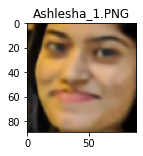

In [0]:
#Crop and Save the selected image 
camera_path = "/content/gdrive/My Drive/images/camera/"
detect_from_camera(selection, path, camera_path)

In [0]:
#Encoding the selected image
person = img_to_encoding(camera_path + selection[0], model)

same_dist_camera = {}                         #door camera database encoding
for name in camera_encodes.keys():
  enc_camera = camera_encodes[name]
  l2_dist = np.linalg.norm(person-enc_camera)
  same_dist_camera[name] = l2_dist

same_dist_db = {}                             #database encoding 
for name in db_encodes.keys():
  enc_db = db_encodes[name]
  l2_dist = np.linalg.norm(person-enc_db)
  same_dist_db[name] = l2_dist

min_dist = min(same_dist_camera.values())      
name = [key for key in same_dist_camera if same_dist_camera[key] == min_dist]

if min_dist > 0.8:
  print("Not a criminal!")
else:                                           
  min_dist2 = min(same_dist_db.values()) 
  name2 = [key for key in same_dist_db if same_dist_db[key] == min_dist2]
  if name2 == name:
    print("A criminal recognized - {}! Alert sent to Police.".format(name[0]))
  else:
    print("Not a criminal!") 

A criminal recognized - Ashlesha! Alert sent to Police.
